In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [2]:
import torch

# Generate a tensor of 200 linearly spaced values from -10 to 10 and reshape it
X = torch.linspace(-10, 10, 200).reshape(-1, 1)


In [3]:
y = 1 / (1 + np.exp(-X))

In [4]:
def calculate_num_params(model):
    """Calculate the number of trainable parameters in the model."""
    num_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
    return num_params


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, in_features=1, hidden1=4, hidden2=8, out_features=1):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, out_features)
        )

    def forward(self, x):
        return self.layers(x)


In [8]:
# Instantiate the model
model = Model()

# Calculate the number of trainable parameters
num_params = calculate_num_params(model)

# Print the number of parameters
print(f"Number of trainable parameters: {num_params}")


Number of trainable parameters: 57


In [9]:
# Calculate the number of parameters for each layer
input_to_hidden1 = 1 * 4  # Parameters from input layer to first hidden layer
hidden1_to_hidden2 = 4 * 8  # Parameters from first hidden layer to second hidden layer
hidden2_to_output = 8 * 1  # Parameters from second hidden layer to output layer

# Calculate the total number of parameters in the model
total_parameters = input_to_hidden1 + hidden1_to_hidden2 + hidden2_to_output

print(f"Total number of parameters: {total_parameters}")


Total number of parameters: 44


In [10]:
# Define the criterion for loss calculation
criterion = nn.CrossEntropyLoss()


In [11]:
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the number of iterations and epochs
num_iterations = 8
epochs = 30
epoch_interval = round(epochs / 3)

# Initialize lists and tensors to store results
model_losses = []
index = 0
layer2_weights_tensor = torch.zeros((num_iterations * epoch_interval, hidden1_to_hidden2))
whole_model_weights_tensor = torch.zeros((num_iterations * epoch_interval, total_parameters))
loss_tensor = torch.zeros((num_iterations * epoch_interval, 1))

for iteration in range(num_iterations):
    # Initialize model, loss function, and optimizer
    model = Model()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        # Feed forward
        y_pred = model(X)
        
        # Compute error
        train_loss = criterion(y_pred, y)
        model_losses.append(train_loss.item())
        
        # Backward and optimize
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        # Every 3 epochs, collect weights and loss of the model
        if (epoch + 1) % 3 == 0:
            # Collect weights of the model from sequential layers
            weights = [layer.weight.flatten().detach().cpu() for layer in model.layers if isinstance(layer, nn.Linear)]
            
            # Reshape weights
            layer1_weights = weights[0].reshape(1, input_to_hidden1)
            layer2_weights = weights[1].reshape(1, hidden1_to_hidden2)
            layer3_weights = weights[2].reshape(1, hidden2_to_output)
            
            # Combine all layer weights for the whole model
            combined_weights = torch.cat((layer2_weights, layer1_weights, layer3_weights), dim=1)
            
            # Save weights and loss
            whole_model_weights_tensor[index] = combined_weights
            layer2_weights_tensor[index] = layer2_weights
            loss_tensor[index] = train_loss.item()
            index += 1


In [17]:
import numpy as np

def perform_pca(data, num_components):
    """
    Perform Principal Component Analysis (PCA) on the given data.

    Parameters:
    - data (np.ndarray): Input data array where rows represent samples and columns represent features.
    - num_components (int): Number of principal components to retain.

    Returns:
    - np.ndarray: Transformed data with reduced dimensionality.
    """
    num_samples, num_features = data.shape
    
    # Compute the mean of each feature
    means = np.mean(data, axis=0)
    
    # Center the data by subtracting the mean
    centered_data = data - means
    
    # Compute the covariance matrix
    covariance_matrix = np.dot(centered_data.T, centered_data)
    
    # Calculate eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    
    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    
    # Select the top num_components eigenvectors
    selected_eigenvectors = sorted_eigenvectors[:, :num_components]
    
    # Project the centered data onto the selected eigenvectors
    reduced_data = np.dot(centered_data, selected_eigenvectors)
    
    return reduced_data


In [18]:
# Convert tensors to numpy arrays and apply PCA
def reduce_dimensions_with_pca(tensor_data, num_components):
    """
    Convert tensor data to numpy array, perform PCA, and return reduced dimensions.

    Parameters:
    - tensor_data (torch.Tensor): Input tensor data.
    - num_components (int): Number of principal components to retain.

    Returns:
    - np.ndarray: Data with reduced dimensionality.
    """
    # Convert tensor to numpy array
    data_np = tensor_data.detach().cpu().numpy()
    
    # Perform PCA
    reduced_data = perform_pca(data_np, num_components)
    
    return reduced_data

# Reduce dimensions using PCA for different datasets
lay2_reduced = reduce_dimensions_with_pca(layer2_weights_tensor, 2)
whole_model_reduced = reduce_dimensions_with_pca(whole_model_weights_tensor, 2)
loss_vector = loss_tensor.detach().cpu().numpy()


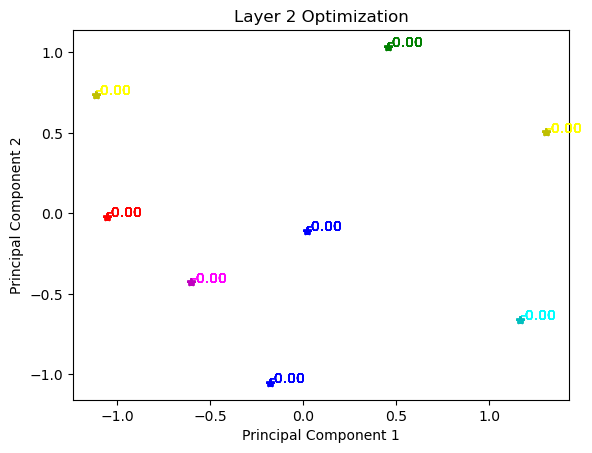

In [19]:
import matplotlib.pyplot as plt

def plot_layer_2_optimization(reduced_data, loss_vector):
    """
    Plot the optimization of Layer 2 of the neural network.

    Parameters:
    - reduced_data (np.ndarray): Data reduced to 2 dimensions using PCA.
    - loss_vector (np.ndarray): Loss values associated with each data point.
    """
    colour_list = ['y*', 'b*', 'g*', 'r*', 'c*', 'm*']
    colour_name_list = ["yellow", "blue", "green", "red", "cyan", "magenta"]
    
    colour_index = 0
    for index, (point, loss) in enumerate(zip(reduced_data, loss_vector)):
        if index % 10 == 0 and index != 0:
            # Change colour
            colour_index = (colour_index + 1) % len(colour_list)
        
        plt.plot(point[0], point[1], colour_list[colour_index])
        plt.annotate(f"{loss[0]:.2f}", (point[0], point[1]), color=colour_name_list[colour_index])
    
    plt.title("Layer 2 Optimization")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

# Call the plotting function
plot_layer_2_optimization(lay2_reduced, loss_vector)


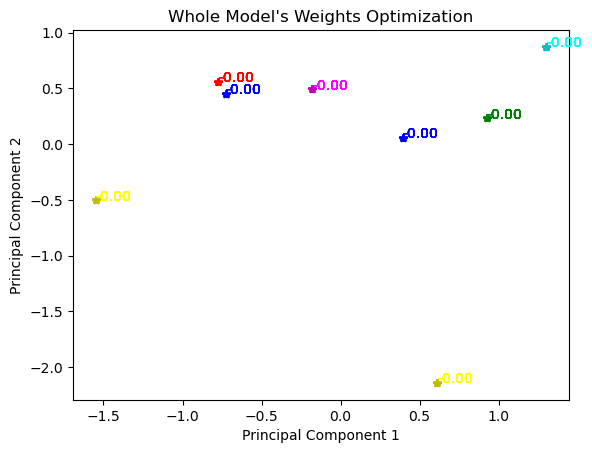

In [20]:
def plot_whole_model_optimization(reduced_data, loss_vector):
    """
    Plot the optimization of the whole model's weights.

    Parameters:
    - reduced_data (np.ndarray): Data reduced to 2 dimensions using PCA.
    - loss_vector (np.ndarray): Loss values associated with each data point.
    """
    colour_list = ['y*', 'b*', 'g*', 'r*', 'c*', 'm*']
    colour_name_list = ["yellow", "blue", "green", "red", "cyan", "magenta"]
    
    colour_index = 0
    for index, (point, loss) in enumerate(zip(reduced_data, loss_vector)):
        if index % 10 == 0 and index != 0:
            # Change colour
            colour_index = (colour_index + 1) % len(colour_list)
        
        plt.plot(point[0], point[1], colour_list[colour_index])
        plt.annotate(f"{loss[0]:.2f}", (point[0], point[1]), color=colour_name_list[colour_index])
    
    plt.title("Whole Model's Weights Optimization")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

# Call the plotting function
plot_whole_model_optimization(whole_model_reduced, loss_vector)
